# ＰＢＲ１倍割れ解消 日足

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import re
import yfinance as yf

pattern = re.compile(r'(.+)\.T')

symbol = '2080.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-07-10 00:00:00+09:00,1217.634591,1229.342616,1217.634591,1225.439941,68616,0.0,0.0,0.0
2024-07-11 00:00:00+09:00,1240.074999,1241.050668,1230.318311,1235.196655,125670,0.0,0.0,0.0
2024-07-12 00:00:00+09:00,1211.780583,1229.342621,1211.780583,1222.512939,138388,0.0,0.0,0.0
2024-07-16 00:00:00+09:00,1229.342612,1234.220956,1227.391275,1228.366943,99083,0.0,0.0,0.0
2024-07-17 00:00:00+09:00,1235.196573,1241.050585,1234.220904,1236.172241,73506,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-01-06 00:00:00+09:00,1213.000000,1213.000000,1201.000000,1206.000000,72990,0.0,0.0,0.0
2025-01-07 00:00:00+09:00,1211.000000,1217.000000,1202.000000,1215.000000,54238,0.0,0.0,0.0
2025-01-08 00:00:00+09:00,1209.000000,1215.000000,1208.000000,1210.000000,15618,0.0,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/2080.T?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=2080.T&crumb=%7B%22finance%22%3A%7B%22result%22%3Anull%2C%22error%22%3A%7B%22code%22%3A%22Unauthorized%22%2C%22description%22%3A%22Invalid+Cookie%22%7D%7D%7D


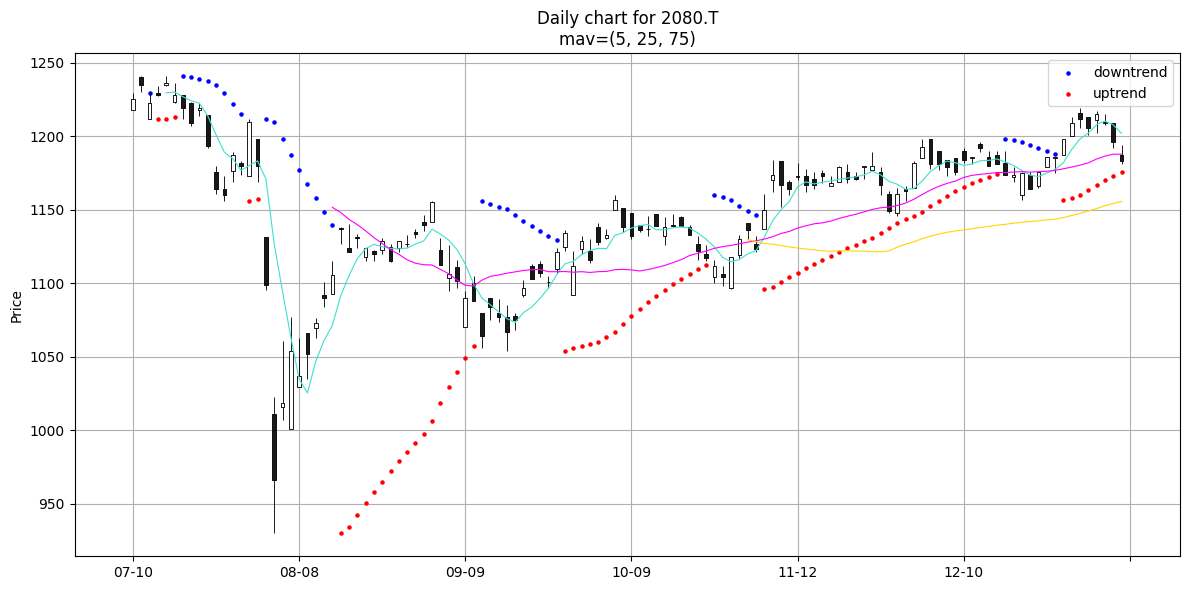

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-01-09 00:00:00+09:00    1196.0
2025-01-10 00:00:00+09:00    1183.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-01-09 00:00:00+09:00     NaN
2025-01-10 00:00:00+09:00   -13.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-01-09 00:00:00+09:00    1207.8
2025-01-10 00:00:00+09:00    1202.0
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-01-09 00:00:00+09:00    1187.84
2025-01-10 00:00:00+09:00    1187.88
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-01-09 00:00:00+09:00    1154.266667
2025-01-10 00:00:00+09:00    1155.680000
Name: Close, dtype: float64